In [1]:
import numpy as np
import h5py
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import skew, kurtosis
from itertools import combinations, combinations_with_replacement
import os
from importlib import reload
from TWOHALO import TWOHALO, _make_mass_mask, _make_nbound_mask
from tqdm import tqdm
from subsample import rejection_sampling

In [2]:
testfile = '/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.0-13.5_M2_13.5-14.0.hdf5'
SOAP_path = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
filename = '/disks/cosmodm/vdvuurst/data/twohalotest_13.5-14_14.5-15.hdf5'

with h5py.File(SOAP_path, 'r') as handle:
    COMvelocity = handle["ExclusiveSphere/100kpc/CentreOfMassVelocity"][:]
    HaloCatalogueIndex = handle["InputHalos/HaloCatalogueIndex"][:]
    SOMass = handle['SO/200_mean/TotalMass'][:] 
    NoofBoundParticles = handle["InputHalos/NumberOfBoundParticles"][:]
    COM = handle["ExclusiveSphere/100kpc/CentreOfMass"][:]
    IsCentral = handle["InputHalos/IsCentral"][:].astype(bool) #set to bool so it can be used as a mask
    boxsize = handle['Header'].attrs['BoxSize'][0]

COM = COM % boxsize
half_boxsize = boxsize / 2


In [ ]:
mass_range_primary = [3.5,4]
mass_range_secondary = [4.5,5]

bound_mask = _make_nbound_mask(NoofBoundParticles, 100)
mass_mask = _make_mass_mask(SOMass, *mass_range_primary) # mass bin of the primaries
central_selection = IsCentral 

# final mask for the primaries, select primaries
primary_mask = bound_mask & mass_mask & central_selection
primary_selection_size = np.sum(primary_mask)
primary_pos = COM[primary_mask] 
primary_vel = COMvelocity[primary_mask]
primary_mass = SOMass[primary_mask] # NOT USED
primary_ID = HaloCatalogueIndex[primary_mask] 

# selection of the secondaries, differs only in mass range
secondary_mass_selection = _make_mass_mask(SOMass, *mass_range_secondary) & bound_mask & central_selection
secondary_selection_size = secondary_mass_selection.sum()
secondary_pos = COM[secondary_mass_selection]
secondary_vel = COMvelocity[secondary_mass_selection]
secondary_mass = SOMass[secondary_mass_selection]
secondary_ID = HaloCatalogueIndex[secondary_mass_selection]

intersection_length = np.intersect1d(primary_ID, secondary_ID).shape[0] 
primaries_are_subset = (intersection_length == primary_selection_size)

# TODO: Think of a better naming convention?
# print(f'\nNow working on {PATH}, writing to {filename}...\n')

# When avoiding self-comparison for primaries that might be a (partial) subset of the secondaries this generally holds
dset_shape = (secondary_selection_size - intersection_length) * (primary_selection_size - intersection_length) + \
                (intersection_length * (secondary_selection_size - 1))

pos_diffs = (secondary_pos[:, None] - primary_pos[None, :] + half_boxsize) % boxsize - half_boxsize
r_squared = pos_diffs[:,:,0]**2 + pos_diffs[:,:,1]**2 + pos_diffs[:,:,2]**2





In [3]:
def subsample_function(r_sq, dropoff: callable, min_sq = 20.13**2, max_sq = 300**2):
    if isinstance(r_sq,float):
        if r_sq < min_sq:
            return 1
        elif r_sq > max_sq:
            return 0
        else:
            return dropoff(r_sq, rmin = min_sq, rmax = max_sq)
    else:
        region = (min_sq < r_sq) & (r_sq < max_sq)
        return np.piecewise(r_sq, [r_sq <= min_sq, region, max_sq <= r_sq],[1, dropoff(r_sq[region],rmin=min_sq, rmax=max_sq), 0])


def power_dropoff(r_sq, rmin, rmax, alpha = 1.5):
    a = 1 / (np.power(rmin,-alpha) - np.power(rmax,-1.5))
    b = -a * np.power(rmax,-alpha)
    return a * np.power(r_sq,-alpha) + b

def linear_dropoff(r_sq, rmin, rmax):
    a = 1 / (rmin - rmax)
    b = - rmax * a 
    return a * r_sq + b

def exponential_dropoff(r_sq, rmin, rmax):
    factor = 1 / (np.exp(rmax) - np.exp(rmin))
    a = np.exp(rmin + rmax) * factor
    b = - np.exp(rmin) * factor
    return a*np.exp(r_sq) + b

def rejection_sample(r_sq, dropoff: callable = power_dropoff, min_sq = 20**2, max_sq = 300**2, maximum = None):
    rng = np.random.uniform(size = r_sq.size)
    subsample_probs = subsample_function(r_sq.flatten(), dropoff = dropoff, min_sq = min_sq, max_sq = max_sq)
    indices = np.where(rng <= subsample_probs)[0]
    if maximum is None:
        return r_sq[indices], indices

    r_sq_sel = r_sq[indices]
    low_part_mask = r_sq_sel <= min_sq
    low_part = r_sq_sel[low_part_mask]
    high_part_sel_indx = np.random.choice(np.arange(len(r_sq_sel))[r_sq_sel > min_sq], size = maximum - low_part_mask.sum())

    return np.concatenate((low_part, r_sq_sel[high_part_sel_indx])), np.concatenate((indices[low_part_mask],indices[high_part_sel_indx]))


#### Radial distributions

40979 112249190 0.03650716766864865
5137089 112249190 4.576504293705817


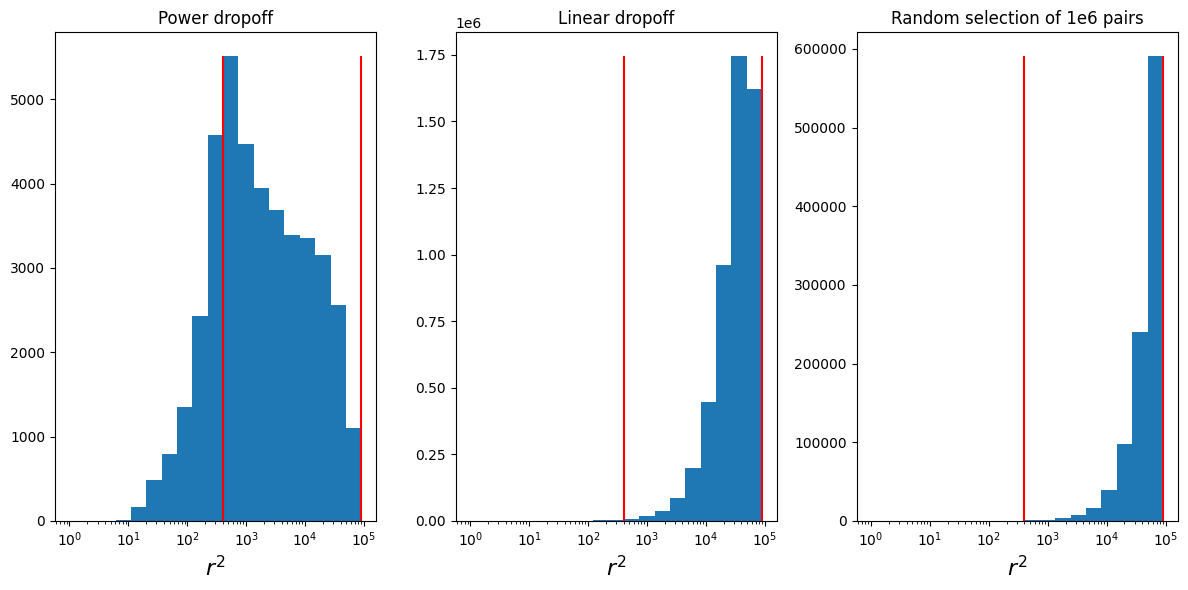

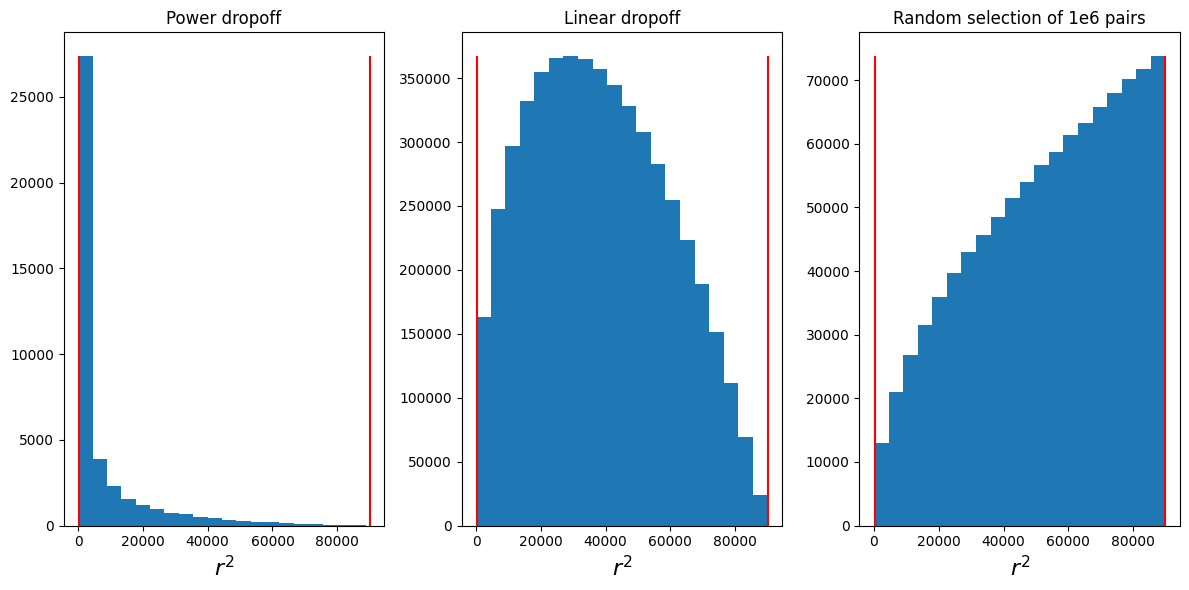

In [5]:
r_squared = r_squared.flatten()
selected_r_sq_power, indx_power = rejection_sample(r_squared)
print(selected_r_sq_power.size, r_squared.size, selected_r_sq_power.size / r_squared.size * 100)

selected_r_sq_lin, indx_lin = rejection_sample(r_squared, dropoff = linear_dropoff)
print(selected_r_sq_lin.size, r_squared.size, selected_r_sq_lin.size / r_squared.size * 100)


fig,(ax1,ax2,ax3) = plt.subplots(ncols = 3,figsize=(12,6))
ax1.set_title('Power dropoff')
ax2.set_title('Linear dropoff')
ax3.set_title('Random selection of 1e6 pairs')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel(r'$r^2$', fontsize= 16)
    ax.set_xscale('log')

bins = np.logspace(0,np.log10(300**2),20)

counts,_,_ = ax1.hist(selected_r_sq_power, bins = bins)
ax1.vlines([20**2,300**2],0,max(counts), colors = 'red')

counts,_,_ =  ax2.hist(selected_r_sq_lin, bins = bins)
ax2.vlines([20**2,300**2],0,max(counts), colors = 'red')

flat_r_sq = r_squared.flatten()
random_choice = np.random.choice(flat_r_sq[flat_r_sq <= 300**2],int(1e6), replace = False)
counts,_,_ =  ax3.hist(random_choice, bins = bins)
ax3.vlines([20**2,300**2],0,max(counts), colors = 'red')

plt.tight_layout()
plt.show()

fig,(ax1,ax2,ax3) = plt.subplots(ncols = 3,figsize=(12,6))
ax1.set_title('Power dropoff')
ax2.set_title('Linear dropoff')
ax3.set_title('Random selection of 1e6 pairs')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel(r'$r^2$', fontsize= 16)
    # ax.set_xscale('log')

# bins = np.logspace(0,np.log10(300**2),20)

counts,_,_ =  ax1.hist(selected_r_sq_power, bins = 20)
ax1.vlines([20**2,300**2],0,max(counts), colors = 'red')

counts,_,_ =  ax2.hist(selected_r_sq_lin, bins = 20)
ax2.vlines([20**2,300**2],0,max(counts), colors = 'red')

flat_r_sq = r_squared.flatten()
random_choice = np.random.choice(flat_r_sq[flat_r_sq <= 300**2],int(1e6), replace = False)
counts,_,_ = ax3.hist(random_choice, bins = 20)
ax3.vlines([20**2,300**2],0,max(counts), colors = 'red')

plt.tight_layout()
plt.show()

#### Full dataset generation

In [7]:
# dset_radial = np.zeros(dset_shape)
# dset_velocities = np.zeros(dset_shape)

# counter = 0
# for i,(pos1, vel1,mass1, id1) in tqdm(enumerate(zip(primary_pos, primary_vel,primary_mass, primary_ID)), total = len(primary_pos)):
#     self_compare_mask = secondary_ID != id1 # Exclude self-comparison

#     if not primaries_are_subset:
#         number_of_comparisons = self_compare_mask.sum()

#     # Positional differences with periodic boundary conditions, without self-comparison
#     pos_diffs = (secondary_pos[self_compare_mask] - pos1 + half_boxsize) % boxsize - half_boxsize
#     radial_distances = np.linalg.norm(pos_diffs, axis=1) 
#     radial_unit_vectors = pos_diffs / radial_distances[:, np.newaxis]

#     # Project velocities to the connecting line between haloes
#     vel_diffs = secondary_vel[self_compare_mask] - vel1
#     projected_vels = np.einsum('ij,ij->i', vel_diffs, radial_unit_vectors)

#     dset_radial[counter:counter+number_of_comparisons] = radial_distances
#     dset_velocities[counter:counter+number_of_comparisons] = projected_vels
#     # dset_sec_masses[counter:counter+number_of_comparisons] = secondary_mass[self_compare_mask]
#     # dset_prim_masses[counter:counter+number_of_comparisons] = np.full(number_of_comparisons, mass1) #fill with the same value to keep the same dset shape

#     counter += number_of_comparisons

# dset_radial = dset_radial[np.nonzero(dset_radial)]
# dset_velocities = dset_velocities[np.nonzero(dset_velocities)]

with h5py.File('/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.0-13.5_M2_13.5-14.0.hdf5','r') as handle:
    dset_radial = handle['radial_distances'][:]
    dset_velocities = handle['velocity_differences'][:]


In [5]:

def vel_hist(radius, velocity):
    number_of_bins = 20
    radial_bins = np.logspace(0, np.log10(300), number_of_bins)

    bin_indices = np.digitize(radius, bins = radial_bins) - 1
    num_bins = len(radial_bins) - 1  

    num_cols = 3
    num_rows = int(np.ceil(num_bins / num_cols))  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()  


    for bin_idx in range(num_bins):
        bin_mask = bin_indices == bin_idx
        bin_velocities = velocity[bin_mask]

        ax = axes[bin_idx]
        ax.set_xlabel("Velocity Difference ")
        ax.set_ylabel("Count")
        ax.set_title(f"{radial_bins[bin_idx]:.2f} - {radial_bins[bin_idx + 1]:.2f} Mpc")

        if len(bin_velocities) == 0:
            ax.remove()
            continue

        counts,_,_ = ax.hist(bin_velocities, bins=50, alpha=0.75, color='b', edgecolor='black')
        try:
            ax.text(np.sort(bin_velocities)[:-2][0],np.max(counts)*0.95, f'Total = {np.sum(counts).astype(np.int32)}', fontsize=14)
        except:
            pass

    return fig, axes
    # plt.tight_layout()
    # plt.show()

#### Linear

In [8]:
selected_r_sq_lin, indx_lin = rejection_sample(dset_radial, dropoff = linear_dropoff,  min_sq = 20.13, max_sq = 300)
# selected_r_sq_lin, indx_lin = rejection_sample(np.square(dset_radial), dropoff = linear_dropoff,  min_sq = 20.13**2, max_sq = 300**2)

selected_vels_lin = dset_velocities[indx_lin]
selected_rad_lin = dset_radial[indx_lin]

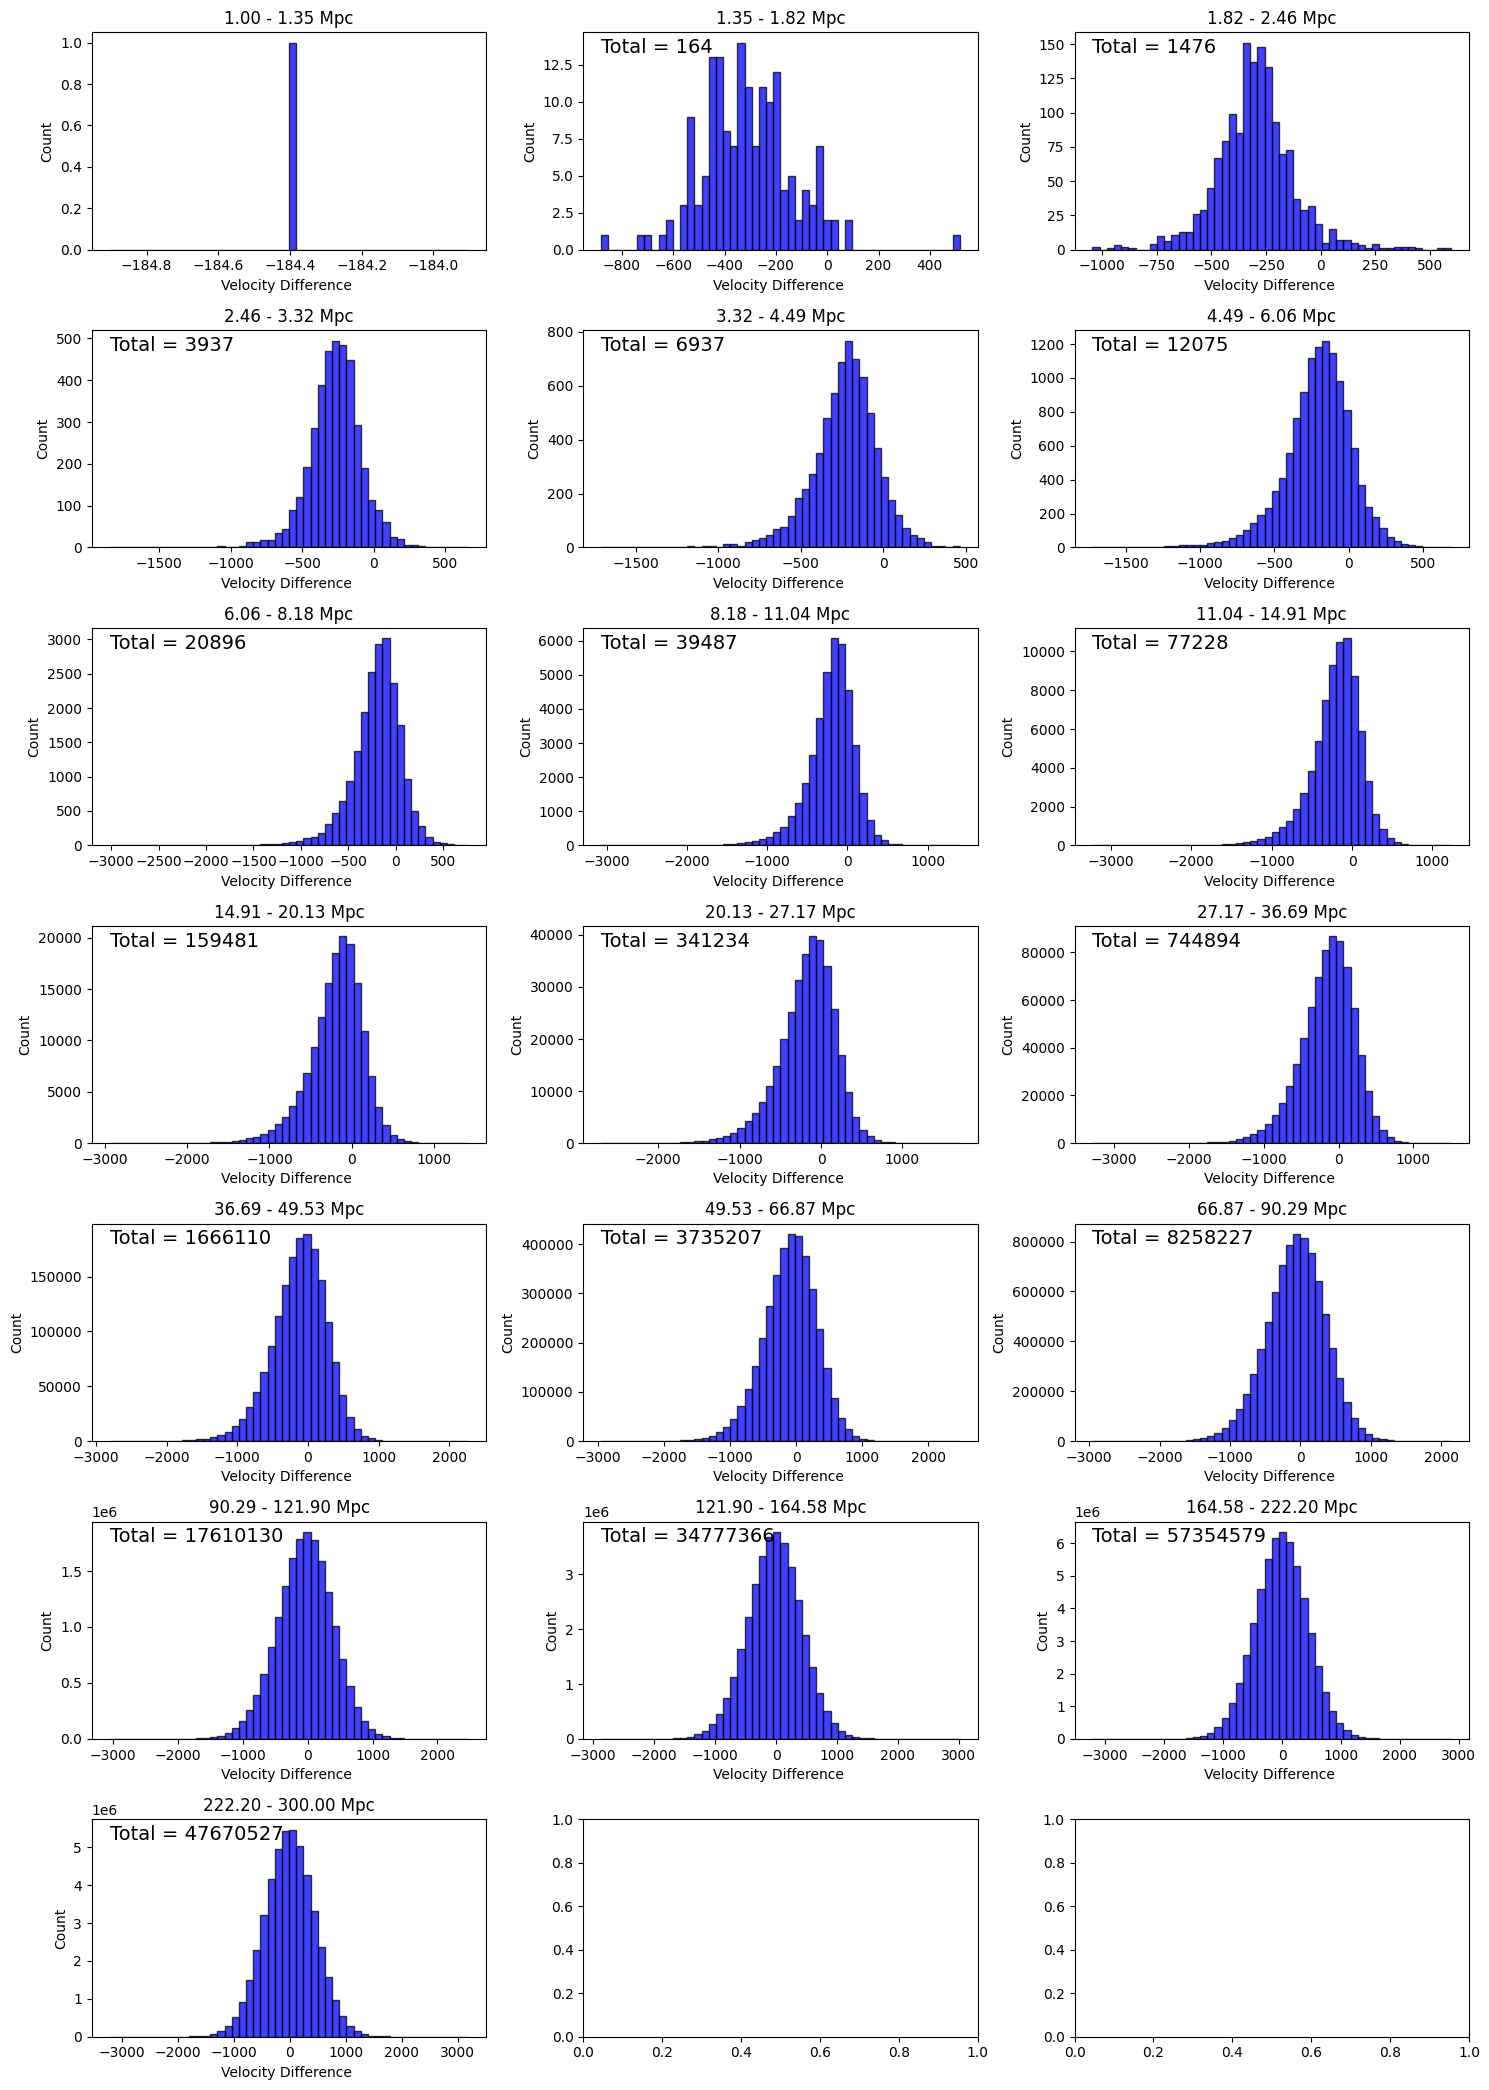

In [9]:
fig, axes = vel_hist(selected_rad_lin, selected_vels_lin)
# fig.suptitle('Linear selection')
fig.tight_layout()
plt.show()

#### Linear with maximum

In [10]:
_, indx_lin_max = rejection_sample(dset_radial, dropoff = linear_dropoff,  min_sq = 20.13, max_sq = 300, maximum = dset_radial.size//100)
# _, indx_lin_max = rejection_sample(np.square(dset_radial), dropoff = linear_dropoff,  min_sq = 20.13**2, max_sq = 300**2, maximum = dset_radial.size//100)

selected_vels_lin_max = dset_velocities[indx_lin_max]
selected_rad_lin_max = dset_radial[indx_lin_max]

print(dset_radial.size//100, selected_vels_lin_max.size)

56701535 56701535


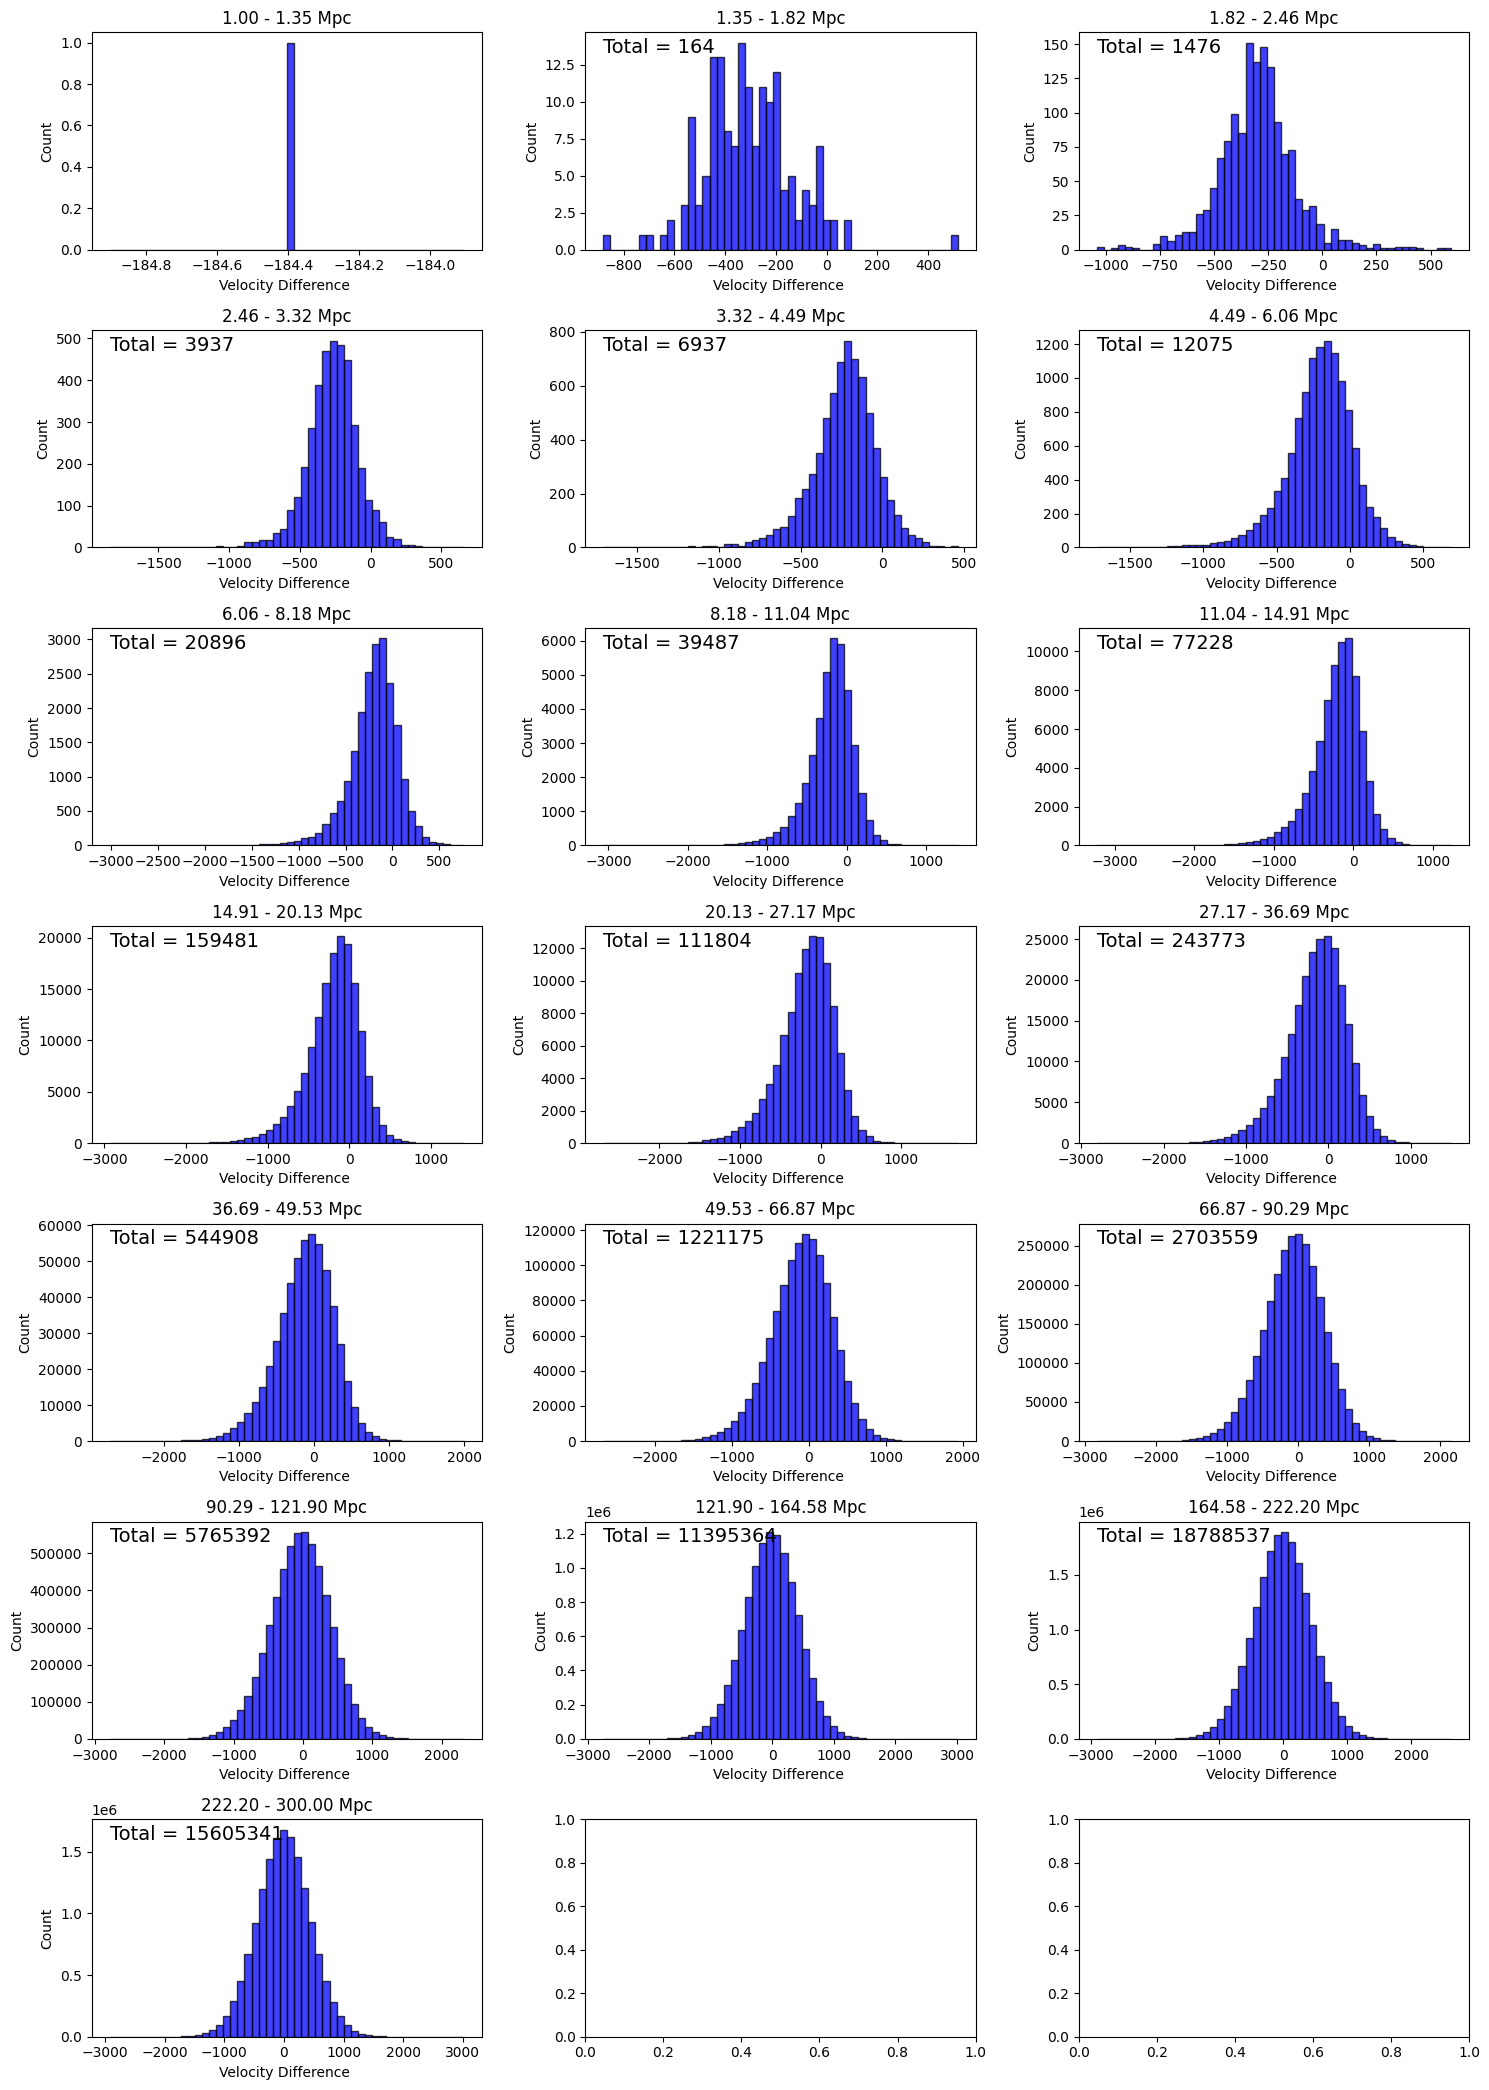

In [11]:
fig, axes = vel_hist(selected_rad_lin_max, selected_vels_lin_max)
# fig.suptitle('Linear selection')
fig.tight_layout()
plt.show()

#### R-squared powerlaw ($\propto r^{-1.5}$)

In [12]:
selected_r_sq_pow, indx_pow = rejection_sample(dset_radial, dropoff = power_dropoff,  min_sq = 20.13, max_sq = 300)
# selected_r_sq_pow, indx_pow = rejection_sample(np.square(dset_radial), dropoff = power_dropoff,  min_sq = 20.13**2, max_sq = 300**2)

selected_vels_pow = dset_velocities[indx_pow]
selected_rad_pow = dset_radial[indx_pow]

In [13]:
print(selected_r_sq_pow.size, dset_velocities.size, selected_r_sq_pow.size / dset_velocities.size * 100)

11440481 5670153550 0.20176668760584093


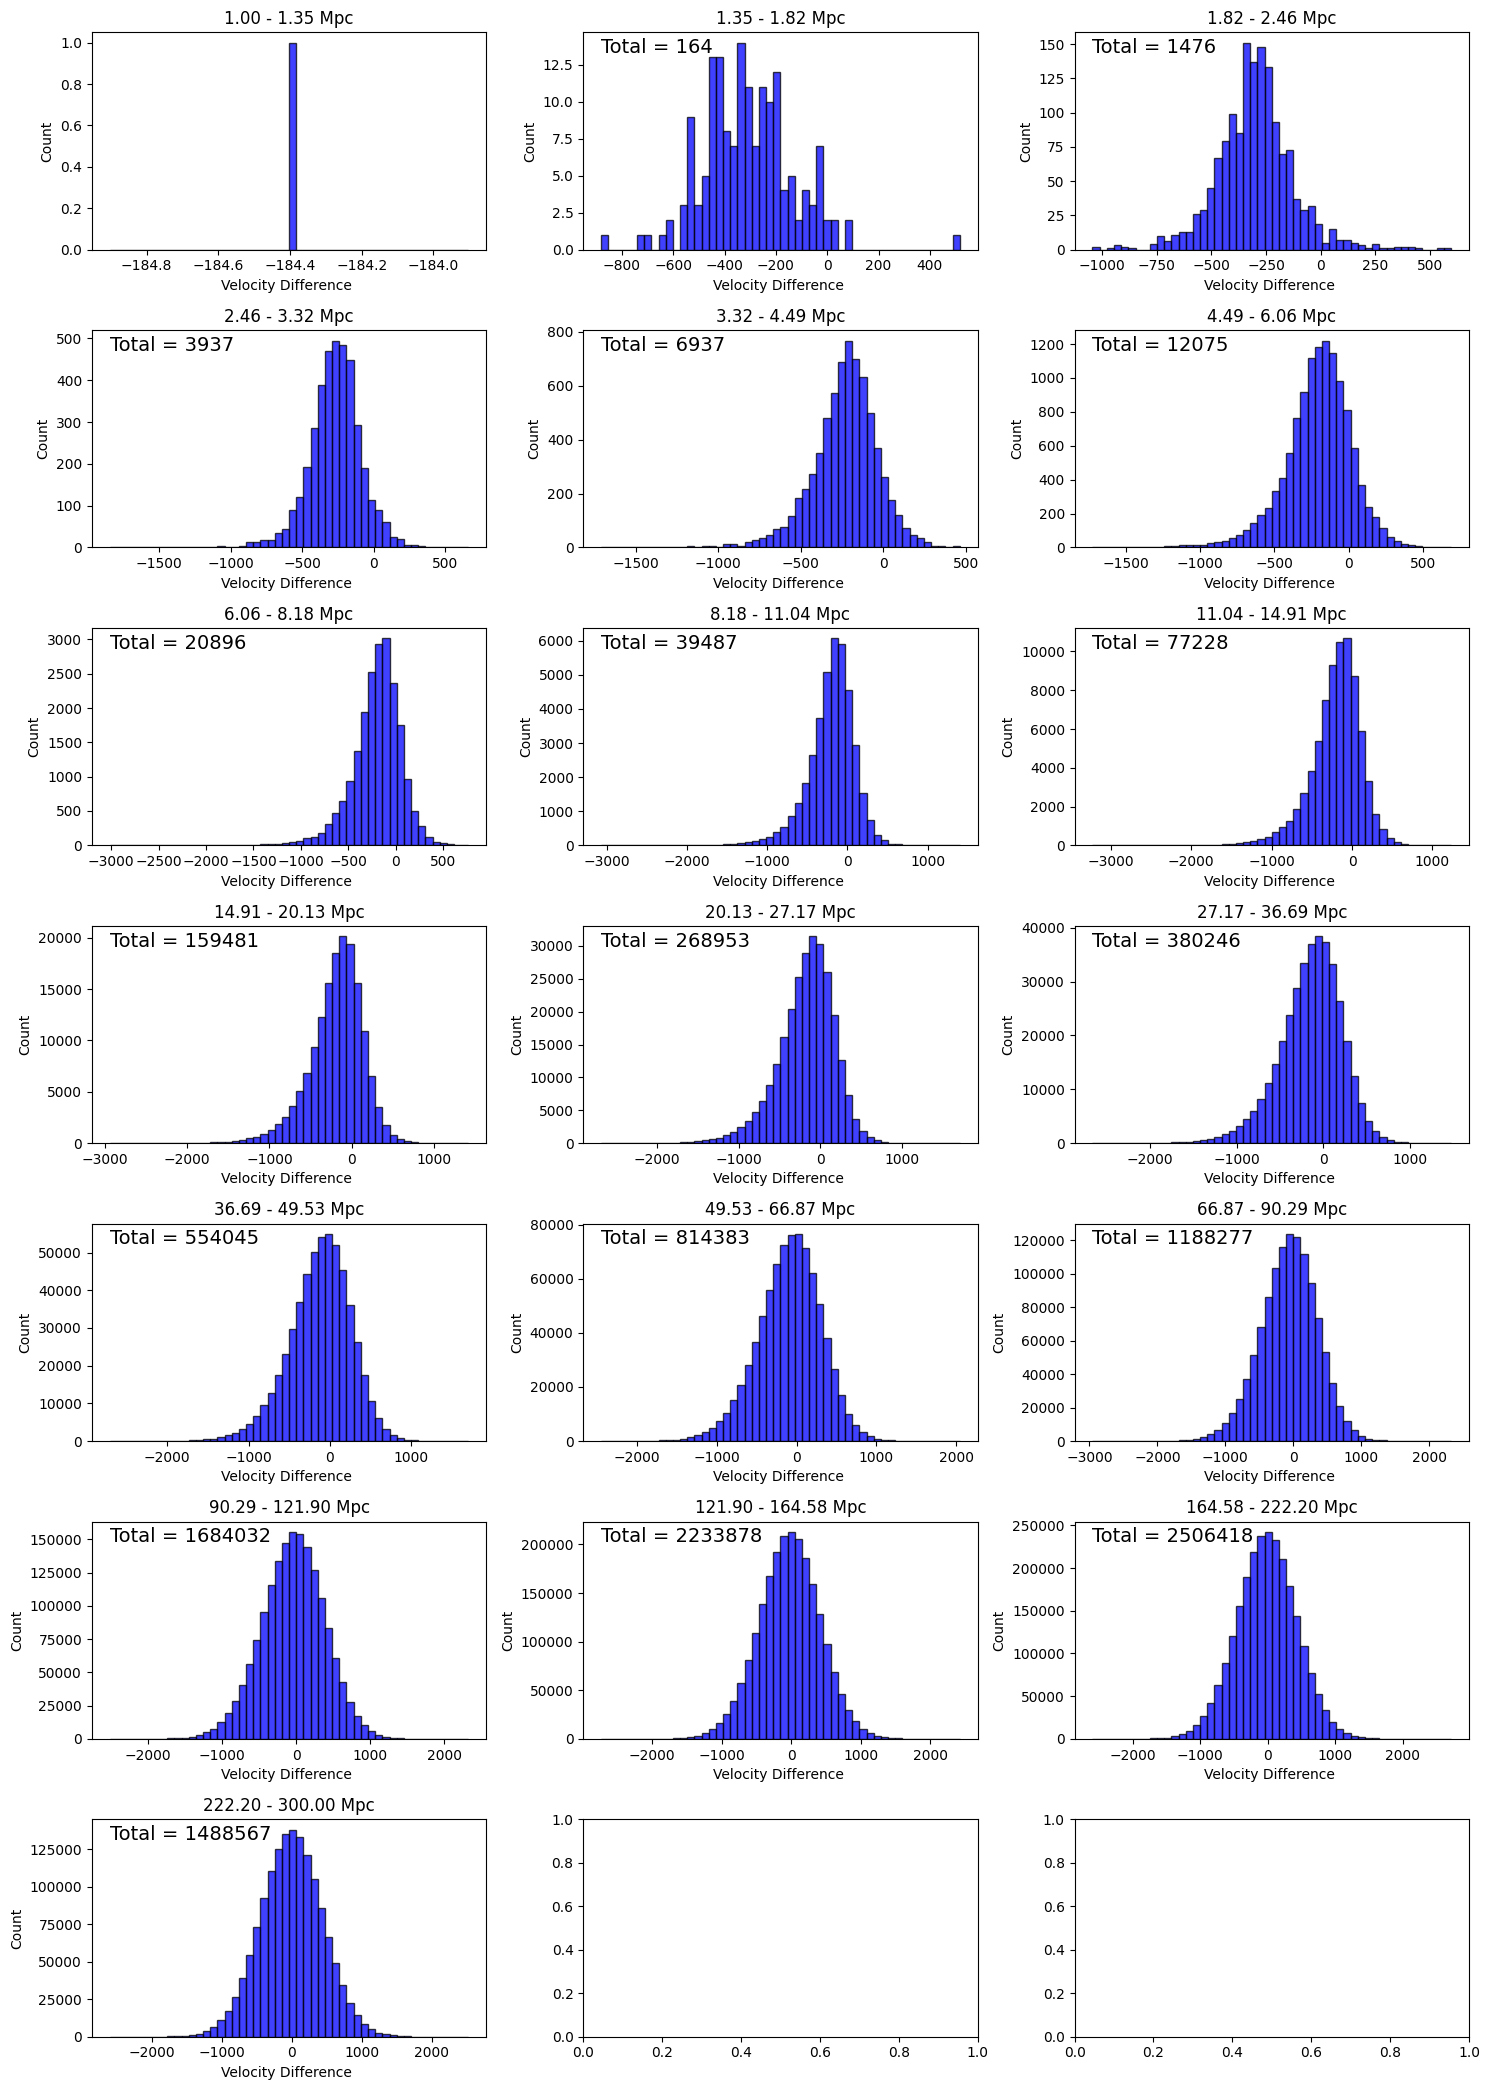

In [14]:
fig, axes = vel_hist(selected_r_sq_pow, selected_vels_pow)
# fig.suptitle('Full selection')
fig.tight_layout()
plt.show()

#### R-squared powerlaw ($\propto r^{-3}$)

In [ ]:
# selected_r_sq_pow, indx_pow = rejection_sample(dset_radial, dropoff = power_dropoff,  min_sq = 20.13, max_sq = 300)
selected_r_sq_pow, indx_pow = rejection_sample(np.square(dset_radial), dropoff = power_dropoff,  min_sq = 20.13**2, max_sq = 300**2)

selected_vels_pow = dset_velocities[indx_pow]
selected_rad_pow = dset_radial[indx_pow]

In [ ]:
print(selected_r_sq_pow.size, dset_velocities.size, selected_r_sq_pow.size / dset_velocities.size * 100)

41254 112249190 0.03675215830065233


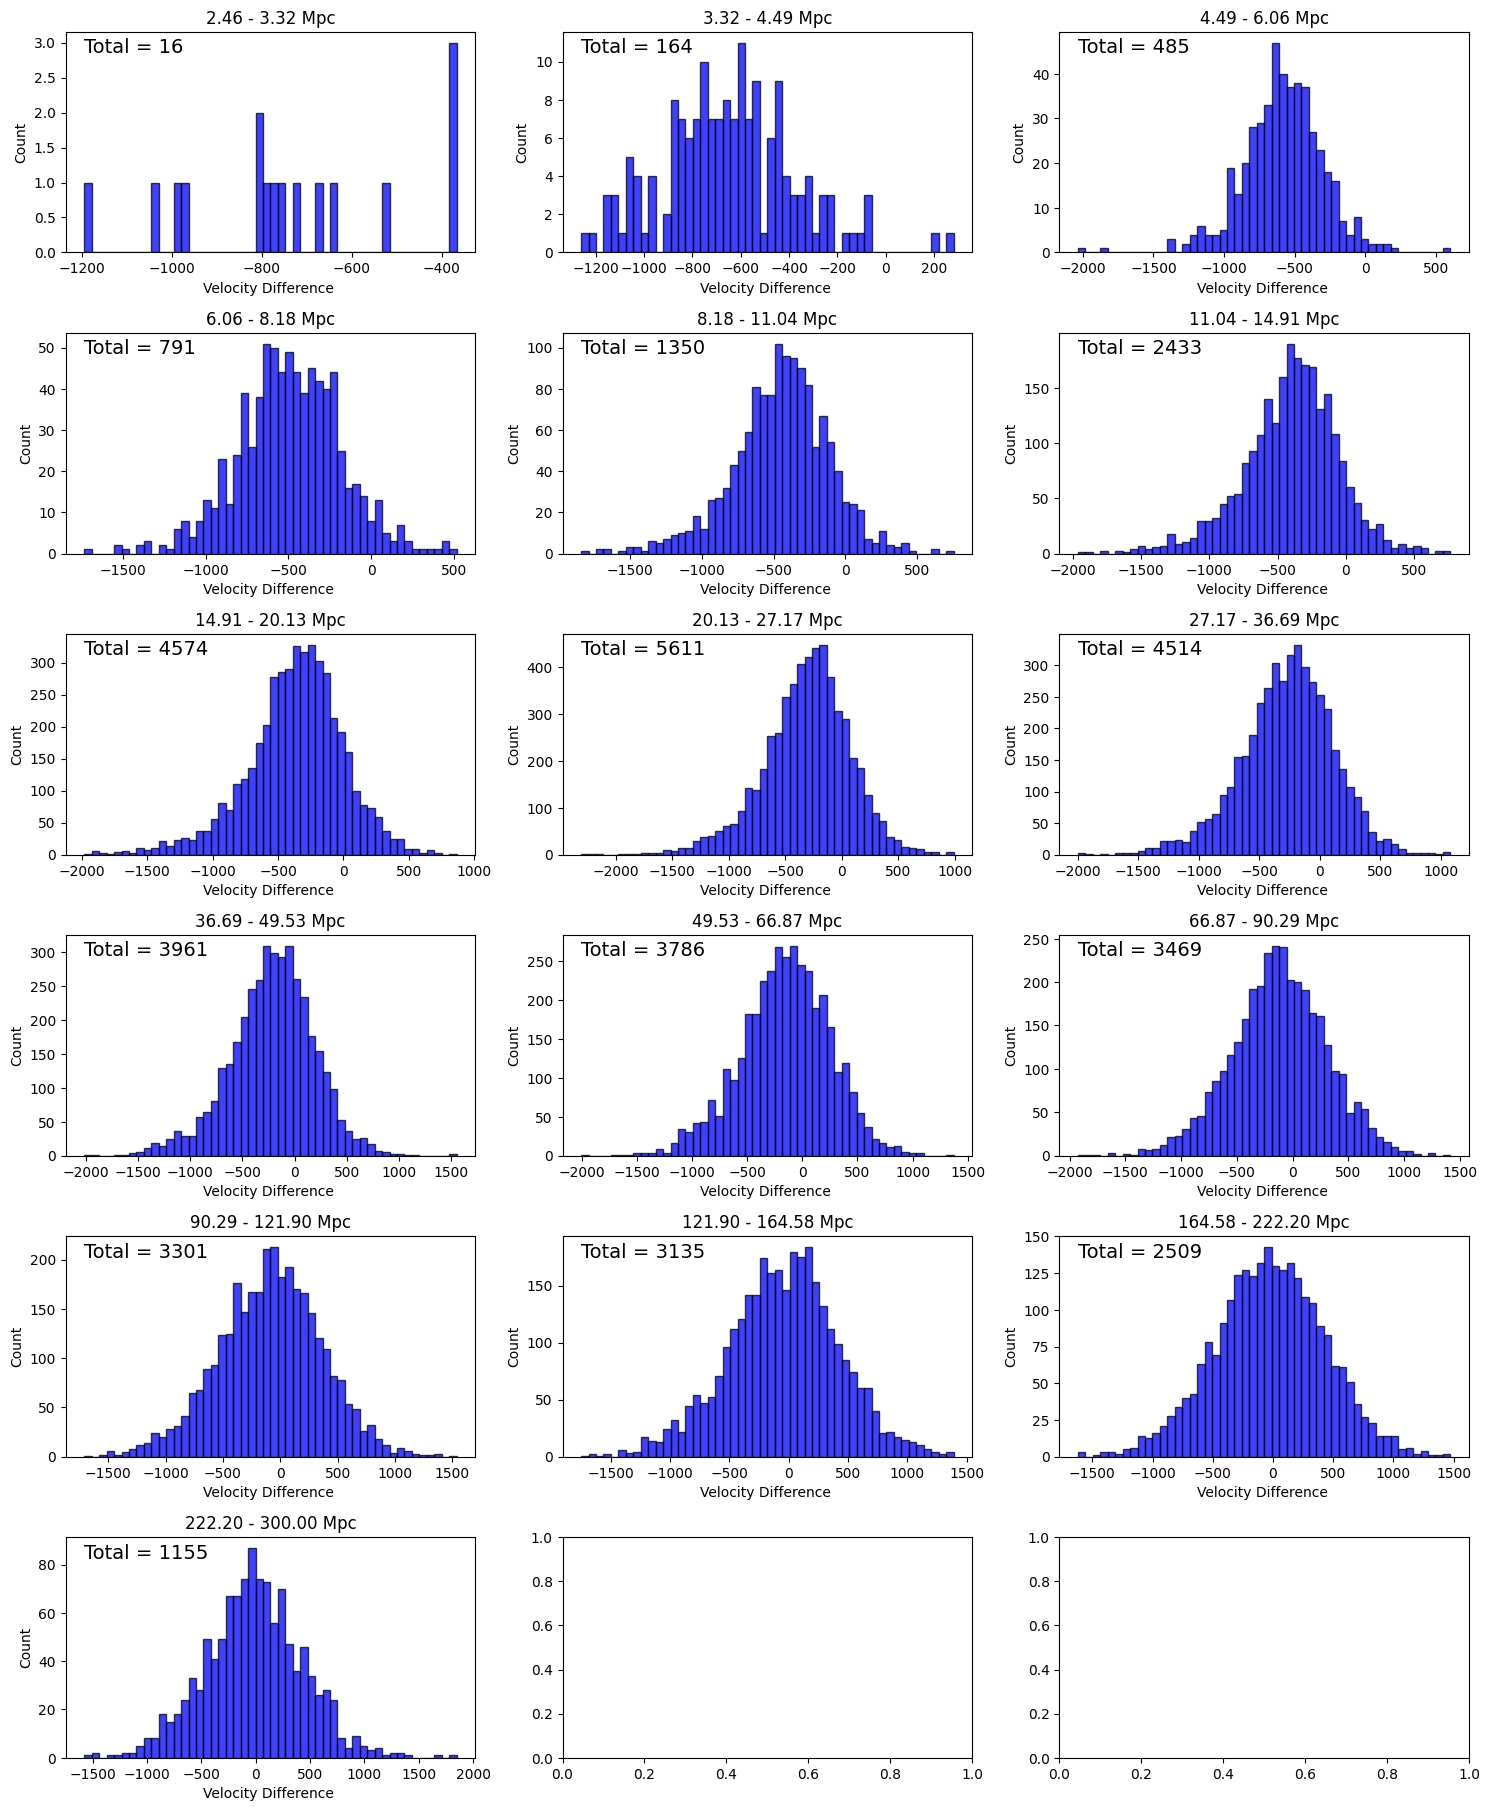

In [ ]:
fig, axes = vel_hist(np.sqrt(selected_r_sq_pow), selected_vels_pow)
# fig.suptitle('Full selection')
fig.tight_layout()
plt.show()

#### Quadratic dropoff

In [ ]:
def quad_dropoff(r_sq,rmin,rmax):
    return power_dropoff(r_sq,rmin,rmax,alpha = 2.)
selected_r_sq_quad, indx_quad = rejection_sample(dset_radial, dropoff = quad_dropoff,  min_sq = 20.13, max_sq = 300)
# selected_r_sq_pow, indx_pow = rejection_sample(np.square(dset_radial), dropoff = power_dropoff,  min_sq = 20.13**2, max_sq = 300**2)

selected_vels_quad = dset_velocities[indx_quad]
selected_rad_quad = dset_radial[indx_quad]
print(selected_r_sq_pow.size, dset_velocities.size, selected_r_sq_pow.size / dset_velocities.size * 100)

234675 112249190 0.20906609660167702


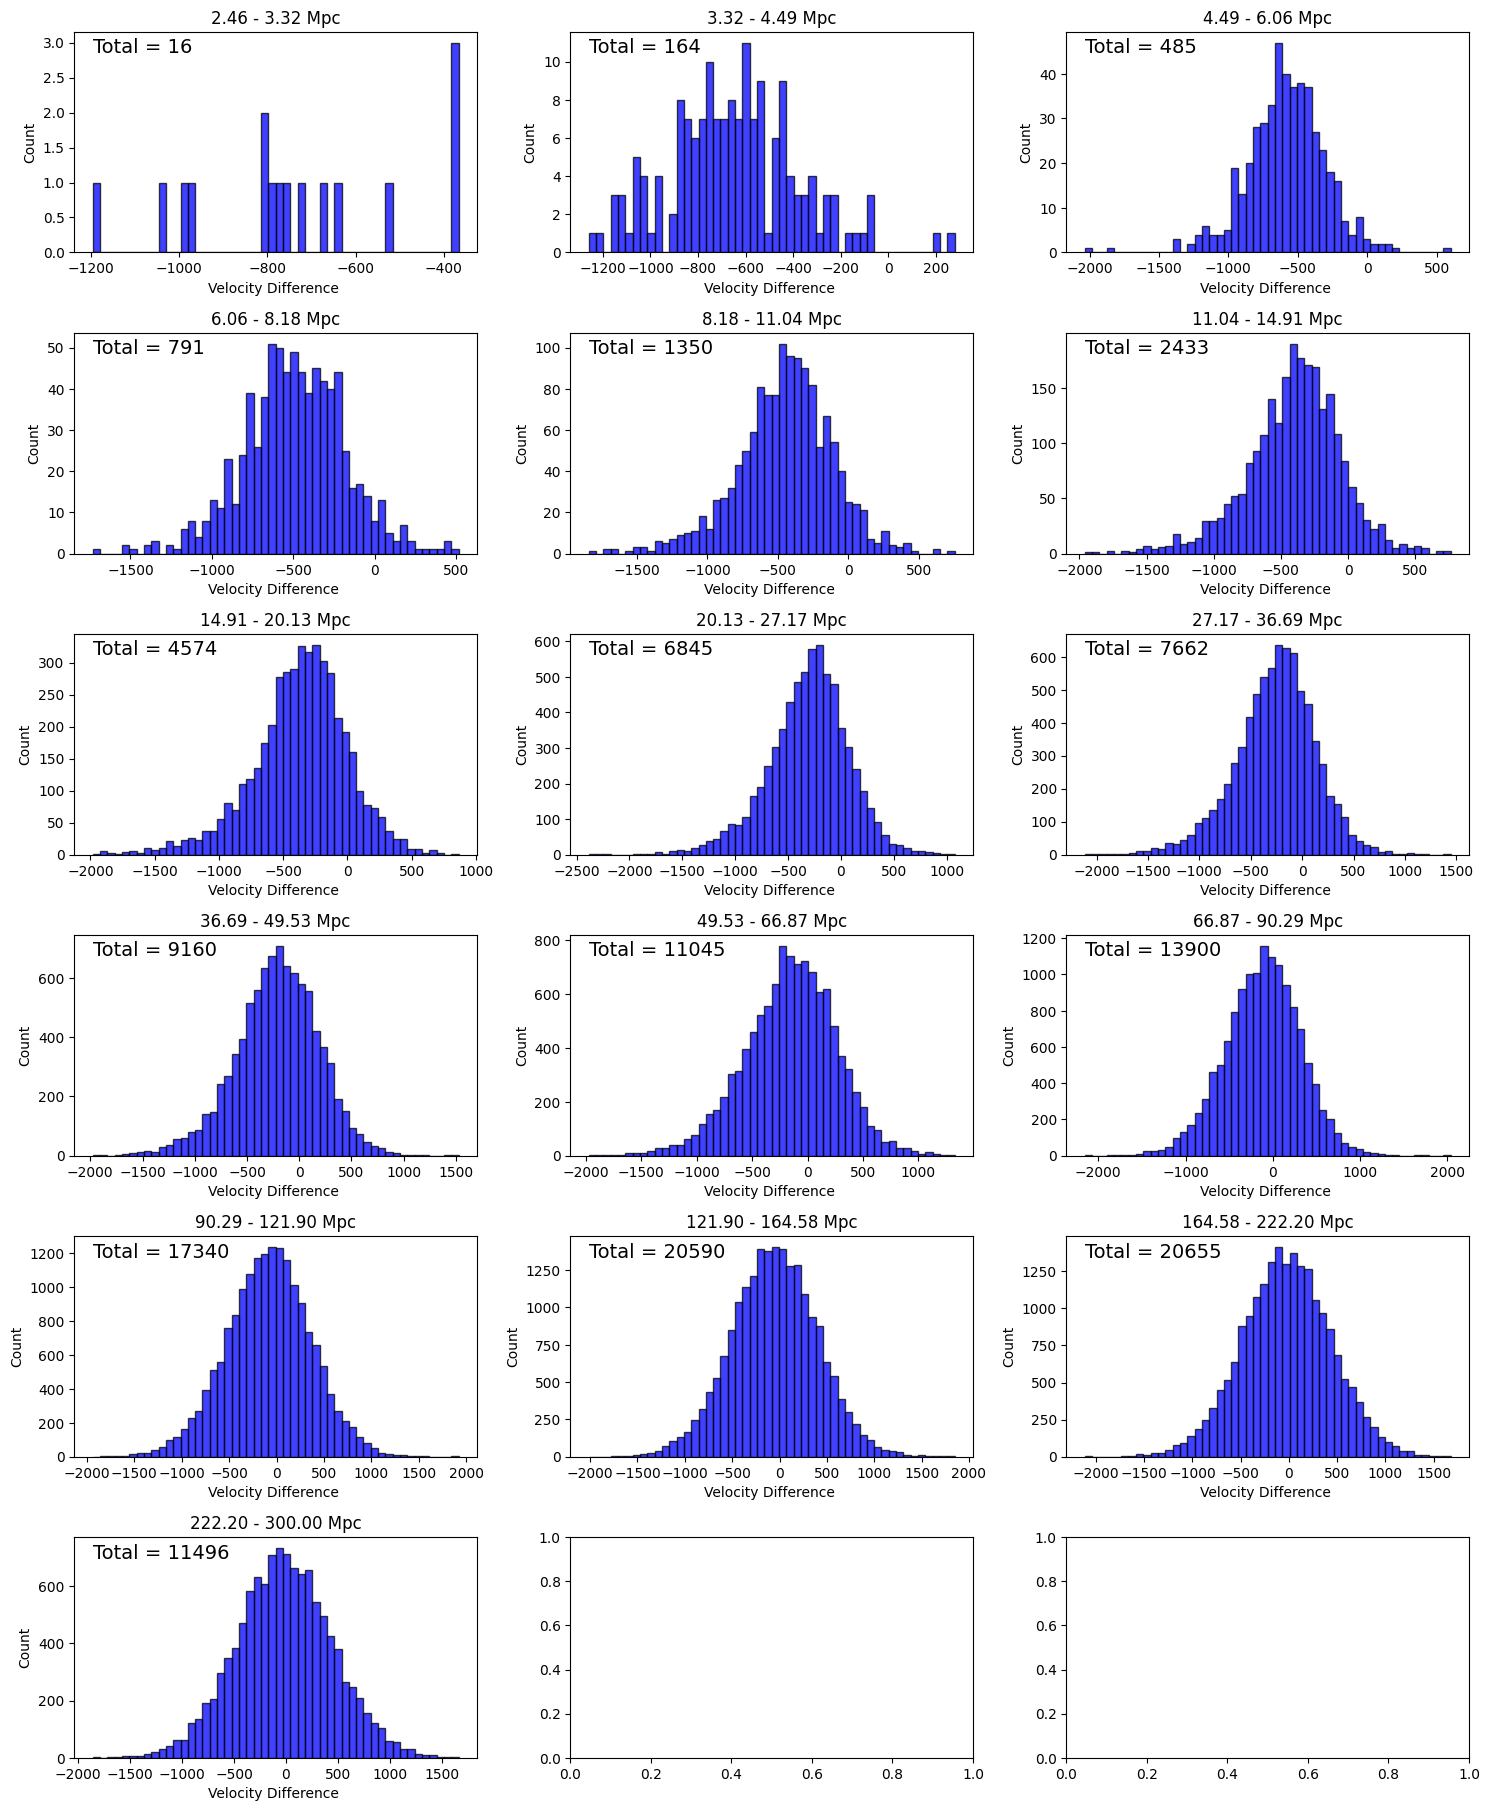

In [ ]:
fig, axes = vel_hist(selected_r_sq_quad, selected_vels_quad)
# fig.suptitle('Full selection')
fig.tight_layout()
plt.show()

#### Full data

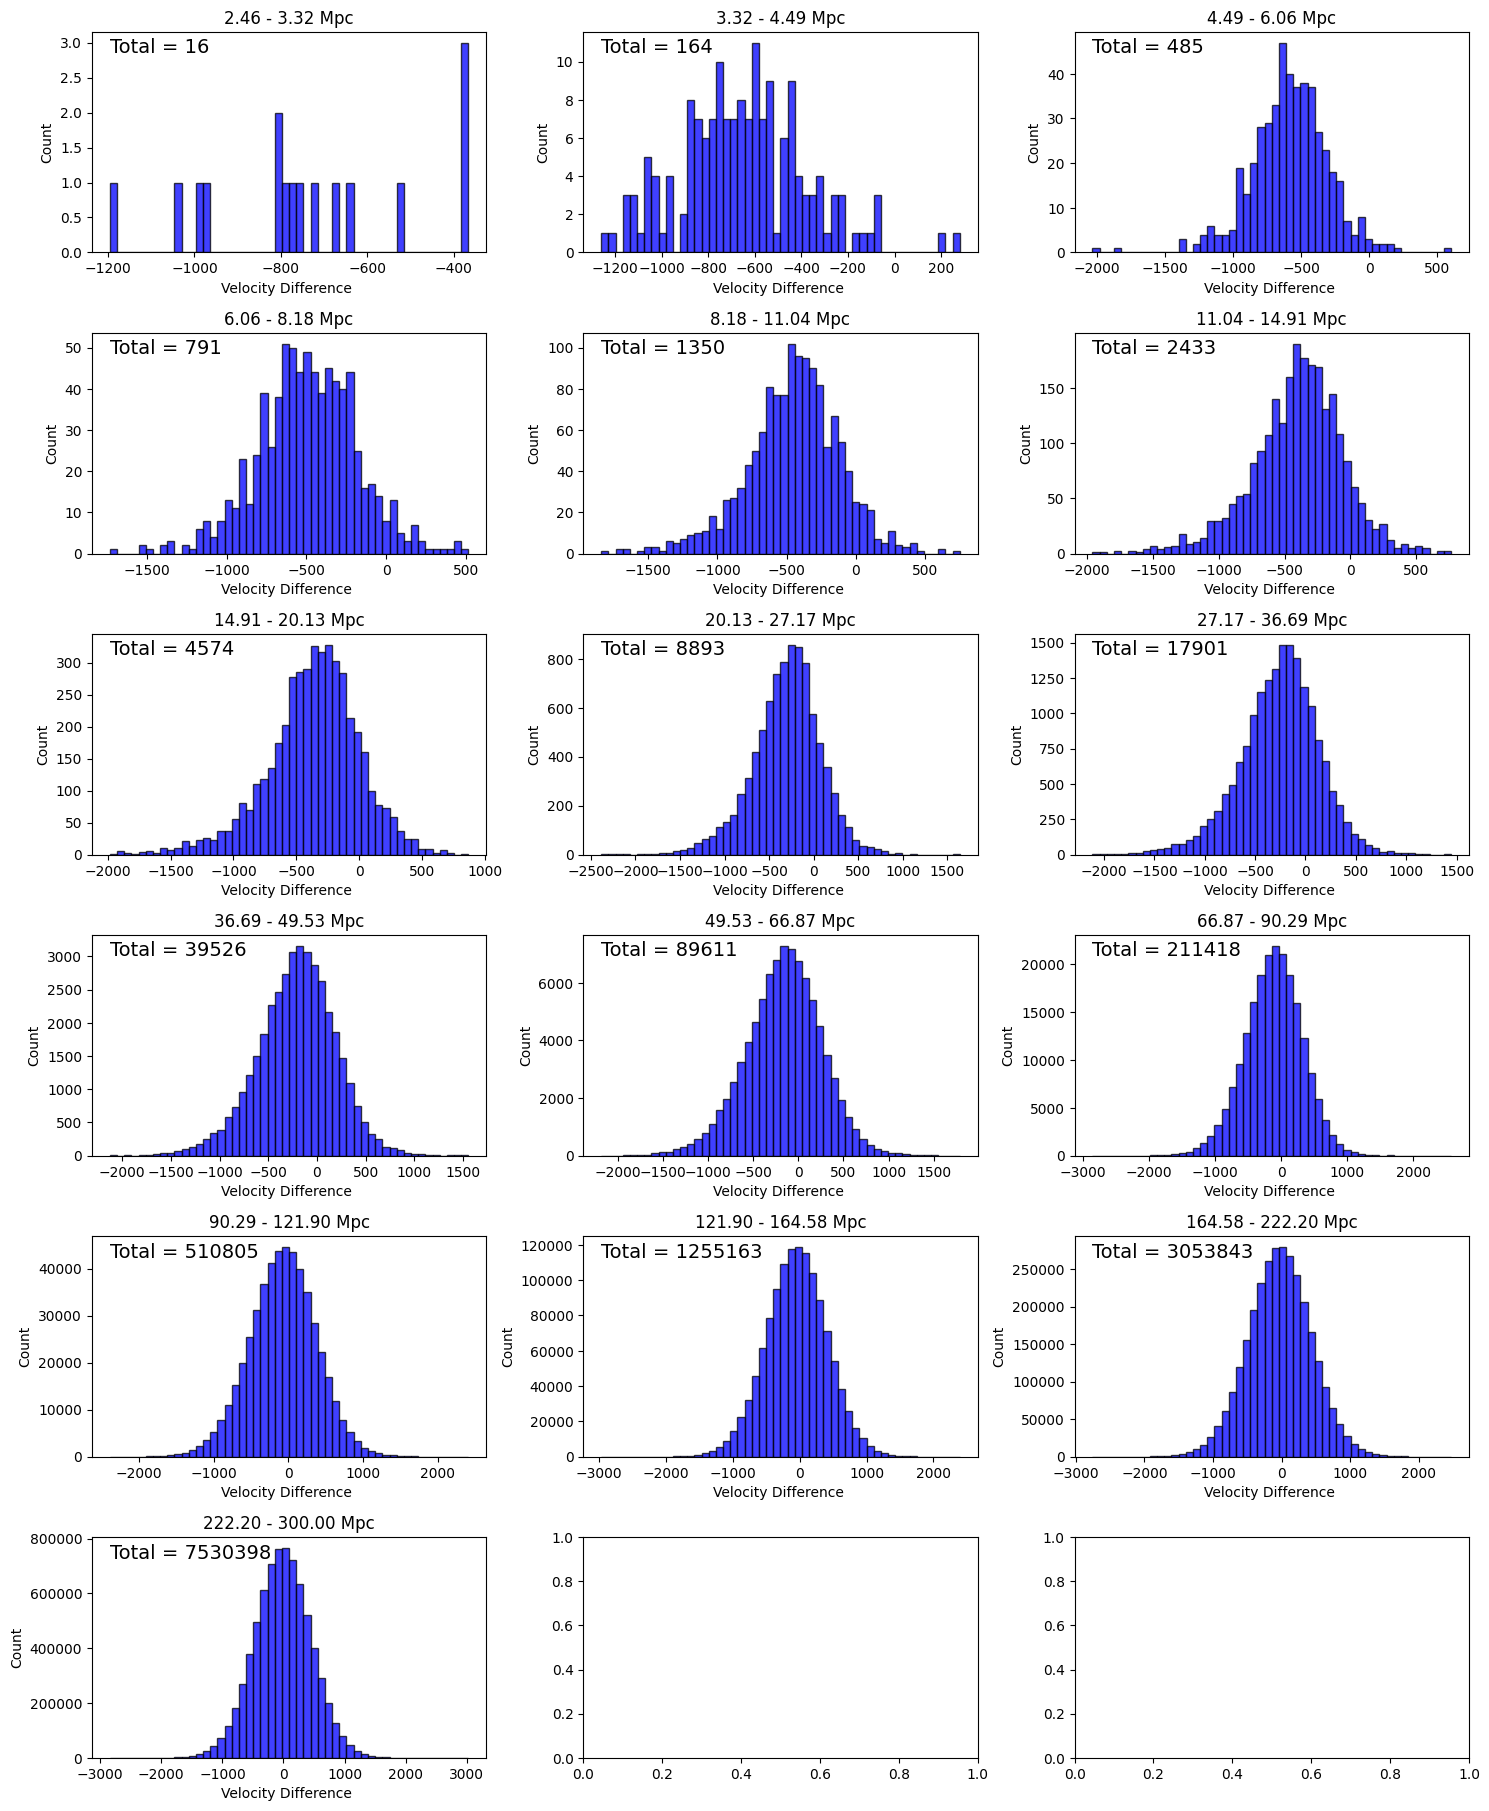

In [ ]:
fig, axes = vel_hist(dset_radial, dset_velocities)
# fig.suptitle('Full selection')
fig.tight_layout()
plt.show()

## In place subsampling

This is done with "power_dropoff" and non-squared distances as input so $\propto r^{-1.5}$ dropoff

In [ ]:
dset_radial = np.zeros(dset_shape)
dset_velocities = np.zeros(dset_shape)

counter = 0
for i,(pos1, vel1,mass1, id1) in tqdm(enumerate(zip(primary_pos, primary_vel,primary_mass, primary_ID)), total = len(primary_pos)):
    self_compare_mask = secondary_ID != id1 # Exclude self-comparison

    if not primaries_are_subset:
        number_of_comparisons = self_compare_mask.sum()

    # Positional differences with periodic boundary conditions, without self-comparison
    pos_diffs = (secondary_pos[self_compare_mask] - pos1 + half_boxsize) % boxsize - half_boxsize
    radial_distances = np.linalg.norm(pos_diffs, axis=1)
    _, subsample_idx = rejection_sample(radial_distances, dropoff = power_dropoff, min_sq = 20.13, max_sq = 300)
    radial_distances = radial_distances[subsample_idx]
    radial_unit_vectors = pos_diffs[subsample_idx] / radial_distances[:, np.newaxis]

    # Project velocities to the connecting line between haloes
    vel_diffs = secondary_vel[self_compare_mask][subsample_idx] - vel1
    projected_vels = np.einsum('ij,ij->i', vel_diffs, radial_unit_vectors)


    # _, subsample_idx = rejection_sample(radial_distances, dropoff = power_dropoff, min_sq = 20.13, max_sq = 300)

    number_of_comparisons = subsample_idx.size    

    dset_radial[counter:counter+number_of_comparisons] = radial_distances
    dset_velocities[counter:counter+number_of_comparisons] = projected_vels
    # dset_radial[counter:counter+number_of_comparisons] = radial_distances[subsample_idx]
    # dset_velocities[counter:counter+number_of_comparisons] = projected_vels[subsample_idx]
  
    counter += number_of_comparisons

dset_radial_sub = dset_radial[np.nonzero(dset_radial)]
dset_velocities_sub = dset_velocities[np.nonzero(dset_velocities)]


100%|██████████| 44210/44210 [00:16<00:00, 2707.81it/s]


In [ ]:
dset_radial.size, dset_radial_sub.size, dset_radial_sub.size / dset_radial.size * 100

(112249190, 235519, 0.20981799512317192)

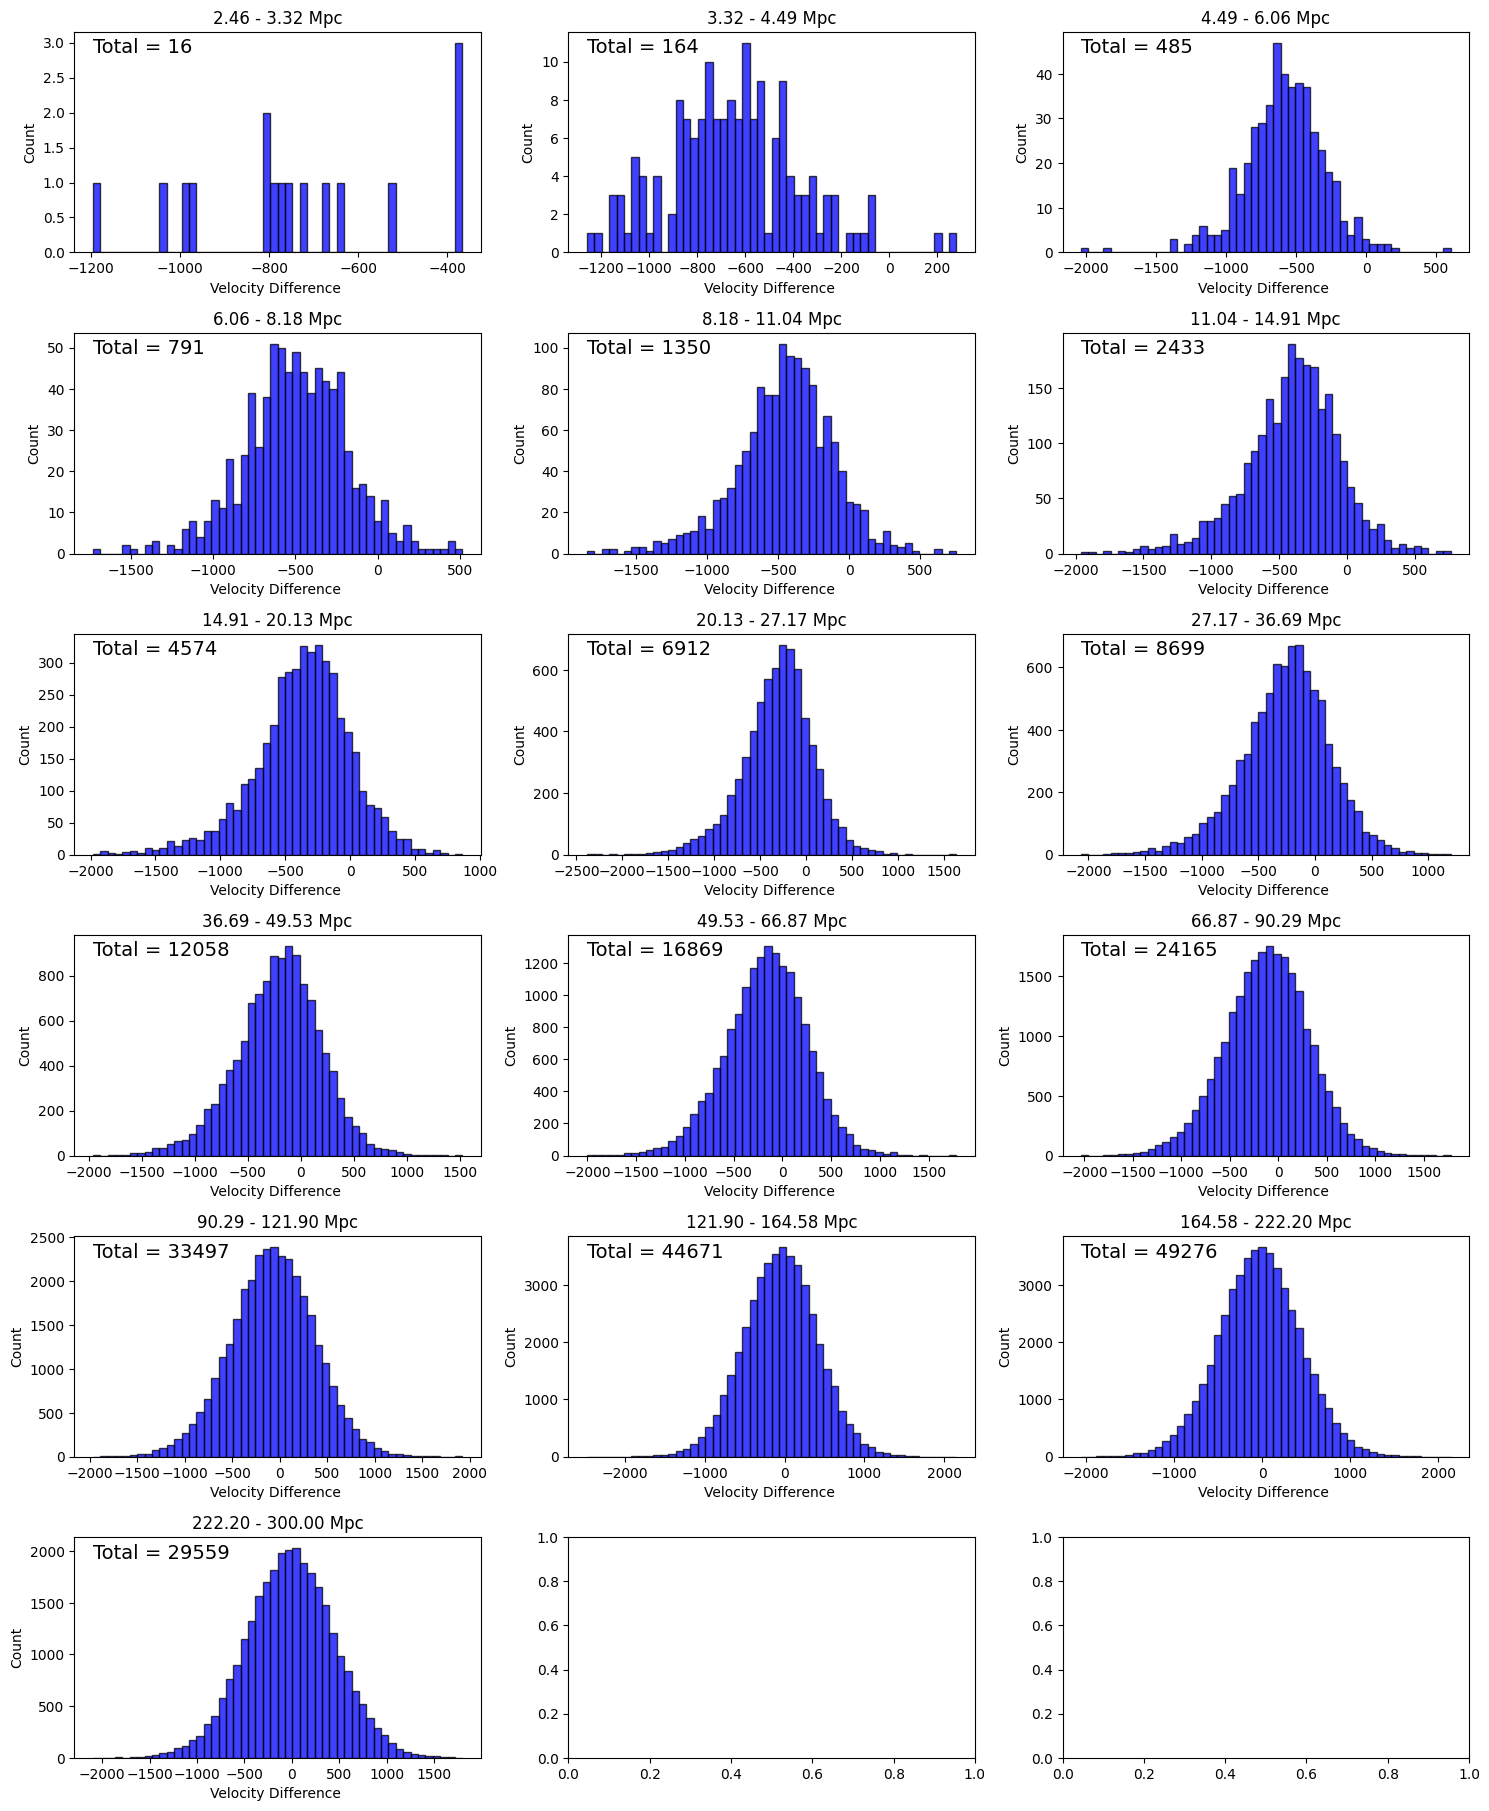

In [ ]:
fig,axes = vel_hist(dset_radial, dset_velocities)
fig.tight_layout()
plt.show()